<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Clustering: DBSCAN. Fundamentos Teóricos.

Este *cuaderno* trata el algoritmo DBSCAN. Este algoritmo es otra de las posibles formas de clustering o agrupamiento de datos. El objetivo del *cuaderno* es que usted aprenda el algoritmo, que sea capaz de reconocer sus características y funcionamiento, y de cómo implementarlo.


**NO** es necesario editar el archivo o hacer una entrega. Sin embargo, los ejemplos contienen celdas con código ejecutable (`en gris`), que podrá modificar  libremente. Esta puede ser una buena forma de aprender nuevas funcionalidades del *cuaderno*, o experimentar variaciones en los códigos de ejemplo.

## Introducción

En este cuaderno abordaremos el algoritmo de DBSCAN que es el algoritmo más usado de los métodos de clustering basados en densidad. El algoritmo DBSCAN (por su nombre en inglés *Density-based spatial clustering of applications with noise*) agrupa los datos en función de las densidades de las observaciones, mientras maneja el ruido de manera eficiente.  El manejo del ruido es una característica única de este enfoque de clustering, ya que no todas las observaciones o puntos de datos deben pertenecer a un agrupamiento, como ocurre con todos los demás enfoques de clustering que estudiamos anteriormente. 

DBSCAN además incorpora  la noción de densidad. Si hay grupos de puntos de datos que existen en el mismo vencindario, estos se pueden ver como miembros del mismo cluster, como por ejemplo en la figura a continuación:

<div style="max-width:500px">
    <img src = "figs/fig_dbscan_neigh.png" />
</div>



Incorporar la noción de densidad tiene una serie de ventajas en comparación a los enfoques anteriores que se enfocan exclusivamente en la disimilitud/distancia. Una de las principales ventajas es el manejo de ruido o valores atípicos. Al incorporar la noción de densidad  en DBSCAN, podemos dejar los valores atípicos fuera de los clústeres. Sólo los puntos de datos que tienen vecinos cercanos se verán como miembros dentro del mismo grupo, y los que están más alejados se pueden dejar como valores atípicos no agrupados. Por otro lado, los clústeres encontrados por este método pueden tener cualquier forma, a diferencia de K-medias y K-medoides que supone clústeres convexos.


Intuitivamente, DBSCAN define un vecindario a partir de un radio y asigna una cantidad mínima de puntos a un cluster. Para ilustrar su funcionamiento consideremos el siguiente ejemplo de una tienda que busca organizar su oferta de vinos de forma tal de tener stock suficiente de sus vinos más populares y al mismo tiempo tener amplia variedad. Un camino que podríamos tomar es agrupar los vinos a partir de sus características, por ejemplo si es vino blanco o tinto; o por sus rasgos químicos. 

Sin embargo, más útil será para la tienda que busca maximizar sus ventas, agrupar los productos a partir de los patrones de compra de sus clientes. El objetivo entonces será tener el stock suficiente de vinos populares, como así también tener  diversidad de forma de satisfacer a clientes con gustos más exóticos o costosos. Esta existencia de productos atípicos hará que la agrupación sea más complicada, especialmente si utilizamos los métodos estudiados hasta el momento, como ser K-medias o Clustering Jerárquico.

DBSCAN entonces se diferencia de K-medias o Clustering Jerárquico porque puede incorporar esta intuición de la manera en que se forman los grupos, pudiendo además eliminar el ruido más eficientemente. Este algoritmo permitirá además señalar a estos distintos tipos de clientes, ya que al utilizar el concepto de vecindario, podemos separar a aquellos clientes atípicos que pueden pensarse como ruido aleatorio, en relación a clientes que regresan una y otra vez a la tienda por los productos más populares.

Antes de avanzar con los detalles, veamos un paso a paso sin códigos ni matemáticas del algoritmo:

1. Comenzamos definiendo dos parámetros: un radio de vecindario, y el mínimo de puntos que consideramos que son suficientes para definir un vecindario.
2. Luego para cada observación calcularemos  la distancia a cualquier otra observación en los datos.
3. Todos los puntos que se encuentran dentro del radio del vecindario que definimos al inicio los consideraremos como vecinos.
4. Verificamos que él número de vecinos debe ser al menos el número que definimos en el primer paso.
    4a. Si se alcanza el umbral mínimo de puntos, los puntos se asignan a un cluster.
    4b. Si no, se marcan como ruido.
6. Repetimos el proceso hasta que todas las observaciones se clasifiquen en grupos o como ruido.

DBSCAN entonces es un algoritmo que es bastante sencillo a pesar de que introduzca conceptos nuevos, como ser el de densidad a través del radio de distancia y de puntos mínimos.


## Implementación de DBSCAN.

Para comprender DBSCAN en un nivel más profundo, en esta sección veremos las matemáticas que respaldan al algoritmo. La idea clave es que para cada punto de un cluster, la vecindad de un radio dado tiene que contener al menos un número mínimo de puntos, es decir, la densidad en la vecindad tiene que exceder algún umbral. La forma de un vecindario está determinada por la elección de una función de distancia para dos puntos $p$ y $q$, denotada por $dist(p,q)$. Por ejemplo, cuando se usa la distancia de Manhattan en un espacio de dos dimensiones, la forma del vecindario será rectangular.

Definimos entonces el primer concepto clave:

* **Vecindario-`eps` de un punto.** El vecindario (`eps`) de un punto $p$, denotado por $N_{eps}(P)$, se define como: 

$$ N_{eps}(P) = \{q\in D | dist(p, q) \leq Eps\}$$

es decir que todos los $q$ que se encuentren a una distancia menor o igual a `Eps` serán parte del vecindario.  Notemos que DBSCAN funciona con cualquier función de distancia siempre y cuando sea adecuada para el tipo de datos bajo estudio. En este cuaderno todos los ejemplos estarán en el espacio de dos dimensiones utilizando la distancia euclidiana, pero los invito a que experimenten con las otras distancias definidas en el *cuaderno de Introducción al Análisis de Clusters*.

Un enfoque de clustering ingenuo podría requerir que para cada punto en un grupo haya al menos un número mínimo (`min_samples`) de puntos en un vecindario `eps` de ese punto. Sin embargo, esto es problemático porque hay dos tipos de puntos en un cluster: puntos dentro del cluster (puntos núcleos o *core points*), y puntos en el borde (puntos límite o *boundary points*).

En general, un vecindario-`eps` de un punto límite contiene significativamente menos puntos que un vecindario-`Eps` de un punto núcleo. Por lo tanto, tendríamos que establecer el número mínimo de puntos (`min_samples`) en un valor relativamente bajo para incluir todos los puntos pertenecientes al mismo grupo. Sin embargo, este valor no será característico del cluster respectivo, particularmente en presencia de ruido. Por lo tanto, requerimos que para cada punto $p$ en un cluster $C$ haya un punto $q$ en $C$, de modo que $p$ esté dentro del vecindario-`Eps`  de $q
$ y $N_{eps}(P)$ contenga al menos puntos `min_samples`. Esto da origen a la siguiente definición: 

* **Punto directamente alcanzable por densidad.** Un punto $p$ es directamente alcanzable por densidad desde un punto $q$ con respecto a un `Eps` y `min_samples` dado si:
    1. $p \in N_{eps}(q)$
    2. $|N_{eps}(q)| \geq min\_samples$
    

La siguiente figura ilustra este concepto:
    
<div style="max-width:400px">
    <img src = "figs/fig1.jpeg" />
</div>

En esta figura el punto $q$ es directamente alcanzable por densidad  desde $p$, pero $p$ no lo es con respecto a $q$. En este respecto, la alcanzabilidad por densidad no es simétrica.
   

 De este concepto se extiende el concepto de *alcanzable por densidad*:
 
* **Alcanzable por densidad.** Un punto $p$ es alcanzable por densidad desde un punto $q$ con respecto a un `eps` y `min_samples` dado, si hay una cadena de puntos $p_1$, $\cdots$, $p_n$, con $p_1 = q$ y $p_n = p$ tal que $p_{i + 1}$ es directamente alcanzable por densidad desde $p_1$. 

    
<div style="max-width:400px">
    <img src = "figs/fig2.jpeg" />
</div>


La figura muestra que un punto $p$ es directamente alcanzable por densidad por $p2$, que a su vez es directamente alcanzable por densidad por $p1$ y que este es directamente alcanzable por densidad $q$. Por lo que, $p\leftarrow p2 \leftarrow p1 \leftarrow q$ forman una cadena. Además, $p$ es alcanzable por densidad desde $q$ pero no viceversa.

Notemos entonces, que dos puntos límites del mismo grupo C posiblemente no sean densidad alcanzable entre sí porque la condición del punto central podría no ser válida para ambos. Sin embargo, debe haber un punto central en C desde el cual ambos puntos límites de C sean alcanzables por densidad. Por lo tanto, es necesario agregar el concepto de *Conectado por densidad* que contempla estos casos:

* **Conectado por densidad** Un punto $p$ está conectado por densidad con $q$ con respecto a un `eps` y `min_samples` dado, si existe un punto $o$ tal que $p$ y $q$ son alcanzables por densidad desde $o$.

<div style="max-width:400px">
    <img src = "figs/fig3.jpeg" />
</div>

La figura anterior, ilustra este concepto de conectado por densidad,donde $p$ y $q$ son alcanzables por densidad desde $o$.

Con estas definiciones, se puede entonces definir un concepto de cluster basados en densidad. Intuitivamente, un cluster será un conjunto de puntos conectados por densidad que es máximo con respecto a la capacidad de alcance de la densidad. El ruido se definirá en relación con un conjunto determinado de clústeres. El ruido es simplemente el conjunto de puntos en $D$ que no pertenecen a ninguno de los clústeres. Formalmente:

* **Cluster.** Sea $D$ conjunto de puntos. El cluster $C$ con respecto a `eps` y `min_samples` es un subconjunto no vacío de $D$ que satisface las siguientes condiciones:
    1. $\forall\ p, q:$ if $p\in C$ y $q$ es alcanzable por densidad por $p$ con respecto a `eps` y `min_samples` dados, entonces $q \in C$.
    2. $\forall\ p, q \in C:$ $p$ está conectado por densidad con $q$ con respecto al `eps` y `min_samples` dados.
    
* **Ruido.** Sean $C_1, \cdots, C_k$ los clústeres conformados a partir de los puntos  $D$ usando los parámetros `eps` y `min_samples` fijos. Definimos como ruido a todos los puntos que no pertenecen a ningún cluster pero están presentes en $D$:

$$ruido = \{p\in D | \forall i: p \notin C_i \}$$


### Ejemplo

En el siguiente ejemplo ilustraremos con un poco más de detalle el funcionamiento del algoritmo. Para ello crearemos un conjunto de datos ficticios con 6 observaciones, que en este punto, podemos pensarlos como su propio cluster [ (1,3) ], [ (-8,6) ], [ (-6,4) ] , [ (4,-2) ], [ (2,5) ], [ (-2,0) ]:

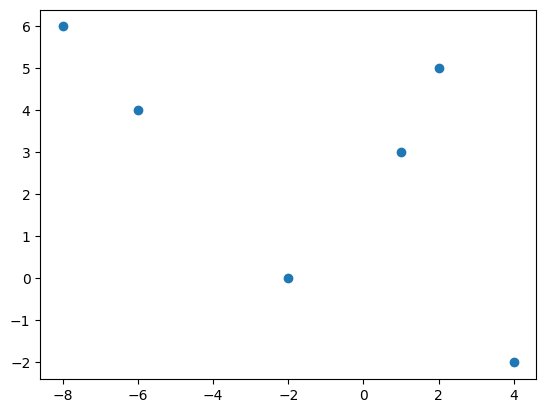

In [1]:
#Cargamos las librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Creamos las 6 observaciones y las graficamos
X =np.array([[1,3], [-8,6], [-6,4] , [4,-2], [2,5], [-2,0]])
plt.scatter(X[:,0], X[:,1])
plt.show()

1. Definimos `eps=5`, es decir, un radio de vecindario de 5 y el mínimo de puntos (`min_samples`) para considerar un vecindario será igual a dos.
2. Calculamos la matriz de distancias (en este caso usaremos las euclidianas, los invito a que experimenten con otras distancias):

In [2]:
from scipy.spatial import distance_matrix

# Creamos la matriz de distancias escogiendo p = 2, el cual convierte 
# la distancia Minkowski en la distancia euclideana
dist = distance_matrix(X, X, p = 2)

# Para visualizar mejor la matriz de distancia, la convertimos en un dataframe
pd.DataFrame(dist)

,0,1,2,3,4,5
0,0.000000,9.486833,7.071068,5.830952,2.236068,4.242641
1,9.486833,0.000000,2.828427,14.422205,10.049876,8.485281
2,7.071068,2.828427,0.000000,11.661904,8.062258,5.656854
3,5.830952,14.422205,11.661904,0.000000,7.280110,6.324555
4,2.236068,10.049876,8.062258,7.280110,0.000000,6.403124
5,4.242641,8.485281,5.656854,6.324555,6.403124,0.000000


3. Con las distancias calculadas, visitamos cada punto y tomamos el radio de distancia definido anteriormente para formar los grupos. Dado que definimos `Eps= 5`, esto significa que dos puntos cualquiera serán vecinos si la distancia entre ellos es inferior a cinco unidades. Por ejemplo, el punto (1,3) tiene puntos (2,5) y (-2,0) como vecinos.
Dependiendo del número de puntos en la vecindad de un punto dado, el punto se puede clasificar en las siguientes tres categorías:
    - *Punto núcleo (o core point)*
    - *Punto límite (o boundary point)*
    - *Ruido (o noise point)*


4. Luego se evalúan los puntos que tienen vecinos para ver si pasan el umbral mínimo de puntos. En este ejemplo, donde definimos como umbral mínimo (`min_samples`) dos puntos, entonces los puntos (1,3), (2,5) y (-2,0) podrían agruparse formalmente como un grupo. 

5. Los puntos que tienen menos vecinos que el número mínimo de puntos vecinos requeridos y cuya vecindad no contiene un punto central se marcan como ruido y permanecen sin agrupar. Por lo tanto, los puntos (-6,4), (4,-2) y (-8,6) entran en esta categoría. Sin embargo, puntos como (2,5) y (2,0), aunque no satisfacen los criterios del número mínimo de puntos en la vecindad, contienen un punto central como su vecino y, por lo tanto, se marcan como puntos límite.

6. La siguiente tabla resume los vecinos de un punto particular y los clasifica como puntos centrales, límites y ruido  para un radio de distancia de 5 y un criterio de vecino mínimo de 2.

| Observación  | Vecinos       | Tiene número mínimo de vecinos | Contiene un punto núcleo como vecino | Clasificación |
|--------------|---------------|--------------------------------|--------------------------------------|---------------|
| (1,3)        | (2,5), (-2,0) | Si                             |            -                         | Punto núcleo  |
| (-8,6)       | (-6,4)        | No                             | No                                   | Ruido         |
| (-6,4)       | (-8,6)        | No                             | No                                   | Ruido         |
| (4,-2)       |    -          | No                             | No                                   | Ruido         |
| (2,5)        | (1,3)         | No                             | Si                                   | Punto límite  |
| (-2,0)       | (1,3)         | No                             | Si                                   | Punto límite  |

7. Repetimos este proceso en los puntos de datos restantes no visitados.

Al final de este proceso, habremos clasificado todas las observaciones en clusters o en ruido. Es importante notar que el desempeño de DBSCAN depende en gran medida de los parámetros elegidos. Asimismo, es importante notar que  DBSCAN no requiere la especificación de grupos apriori como K-medias o K-medoides, permitiendo que DBSCAN funcione mejor para conjuntos de datos complejos, no convexos, y que presentan valores atípicos y ruido.



### DBSCAN paso a paso en `Python`

Ilustremos ahora como implementaríamos DBSCAN desde cero en `Phyton`. Como lo hicimos ya anteriormente, vamos a generar datos que pertenecen a distintos clústeres, y vamos a fingir que desconocemos estos clústeres. Luego vamos a implementar DBSCAN y ver que tan buen trabajo hace.

Comencemos entonces, generando los datos ficticios usando la función `make_blobs` de la librería `Scikit-learn`. Crearemos 1000 observaciones con 2 atributos que perteneces a 8 clústeres. Para hacer replicable el ejercicio, elegiremos la semilla (`random_state`) `800` (te invito a probar cambiando la semilla):


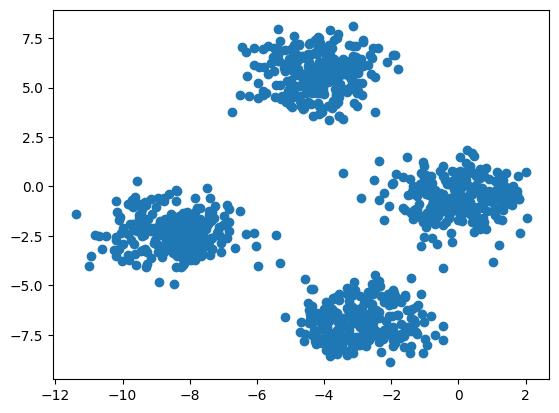

In [3]:
#Cargamos las librerías a utilizar
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np



#Creamos las  observaciones y las graficamos
X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=800)

plt.scatter(X[:,0], X[:,1])
plt.show()

En la práctica, podemos utilizar  la librería `Scikit-learn` que contiene la función de DBSCAN: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html. Su implementación es sencilla y entre sus parámetros se destacan:

    - `eps`: corresponde a la maxima distancia entre dos observaciones para que estas se consideren parte del vecindario. Este es el parámetro más importante de elegir apropiadamente.

    - `min_samples`: es el número de observaciones en un vecindario para que un punto sea considerado un punto núcleo. Este incluye al punto mismo.

    - `metric`: es la medida de distancia a utilizarse. Por default utiliza la distancia euclidiana.

Estos tres son los parámetros más importantes, pero la función admite más parámetros. Los invito a explorar, modificar y experimentar qué sucede cuando se cambian los otros parámetros incluidos en la función.

Importemos e implementemos esta función usando `eps=0.7` y `min_samples=4`:

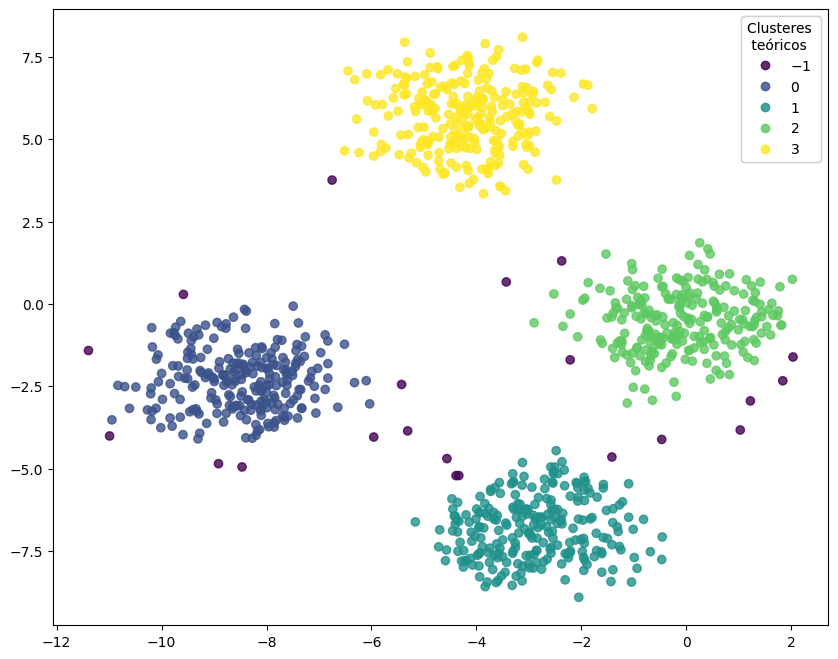

In [4]:
#Importamos la función DBSCAN 
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.7, min_samples=4)
clusters=db.fit_predict(X)


fig, ax = plt.subplots(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
g = plt.scatter(X[:,0], X[:,1], c = clusters, alpha = 0.8)
legend = ax.legend(*g.legend_elements(), loc = "upper right", title = "Clusteres \n teóricos")
ax.add_artist(legend)
plt.show()


Podemos ver que el algoritmo separa claramente 4 grupos y clasifica a puntos más alejados como ruido designándolo con (-1).

#### Elección de `eps`

Anteriormente mencionamos que `eps` es el parámetro más importante de elegir apropiadamente. Veamos como cambian los resultados usando diferentes tamaños del mismo:

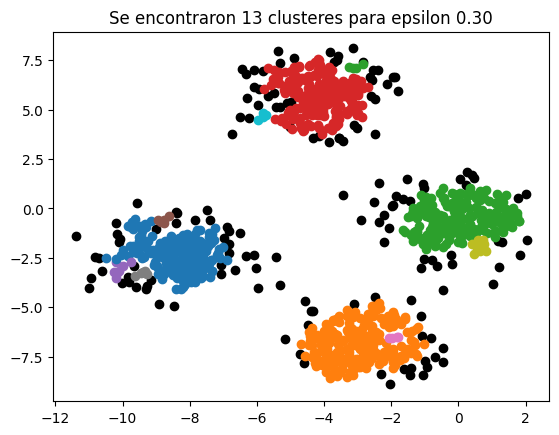

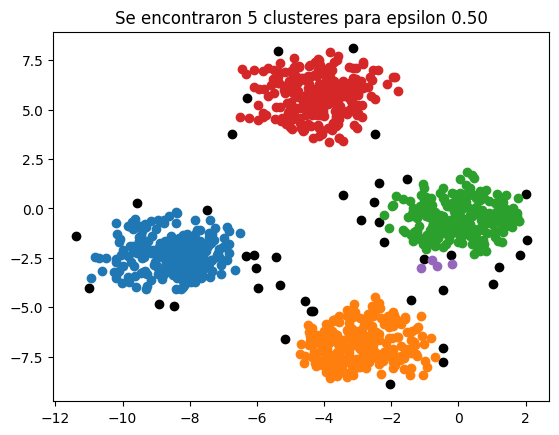

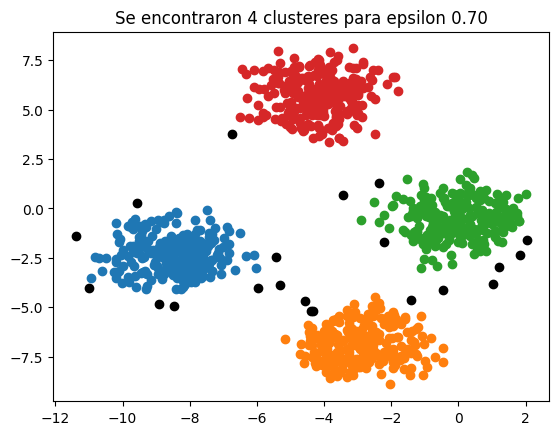

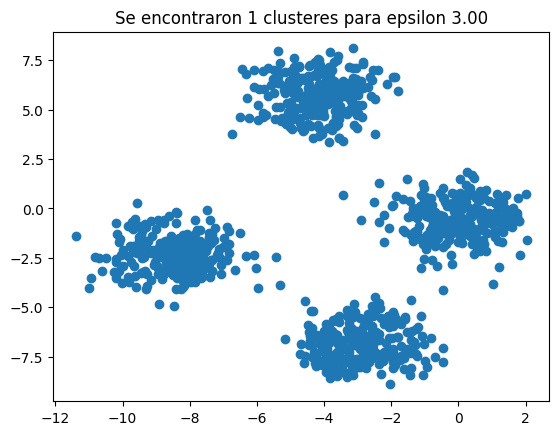

In [5]:
for e in [0.3, 0.5, 0.7, 3]:
    db = DBSCAN(eps = e, min_samples = 4).fit(X)
    clusteres = db.labels_
    n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
    resultado = pd.DataFrame(X).assign(Cluster = clusteres)
    plt.figure()
    for k in np.unique(clusteres):
        if k != -1:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0], 
                y = resultado.loc[resultado.Cluster == k, 1]
                )
        else:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0], 
                y = resultado.loc[resultado.Cluster == k, 1],
                c = "black"
                )
    plt.title('Se encontraron %d clusteres para epsilon %0.2f' % (n_clusteres, e))



Como podemos ver en las gráficas, al fijar el `eps`  demasiado pequeño, la mayoría de los datos no se agruparán en absoluto y se etiquetarán como ruido (puntos negros). Cuando se elige demasiado grande, hace que los clústeres cercanos se fusionen en un cluster y, finalmente, todo el conjunto de datos se devuelva como un solo clúster. 

Para tratar de encontrar `eps` de una manera más robusta, Rahmah y Sukaesih (2012) sugirieron un método para hacerlo. Estos autores sugieren calcular la distancia a los `min_samples` más cercanos de cada punto y posteriormente ordenar los resultados de menor a mayor. Luego se grafican los resultados en donde el eje $x$ corresponde al índice y el eje $y$ a la distancia. El valor óptimo de `eps` será el punto donde se encuentre la mayor curvatura en la gráfica. 

Intuitivamente, cuando los radios comienzan a aumentar de forma exponencial (el codo de la curva) significa que nos alejamos de la zona de alta densidad (valores normales) y entramos en la zona de baja densidad (valores atípicos).

Podemos calcular la distancia desde cada punto a su vecino más cercano usando `NeighborsNeighbors`. Este método devuelve dos matrices, una que contiene la distancia a los `n_neighbors` puntos más cercanos y la otra que contiene el índice para cada uno de esos puntos.

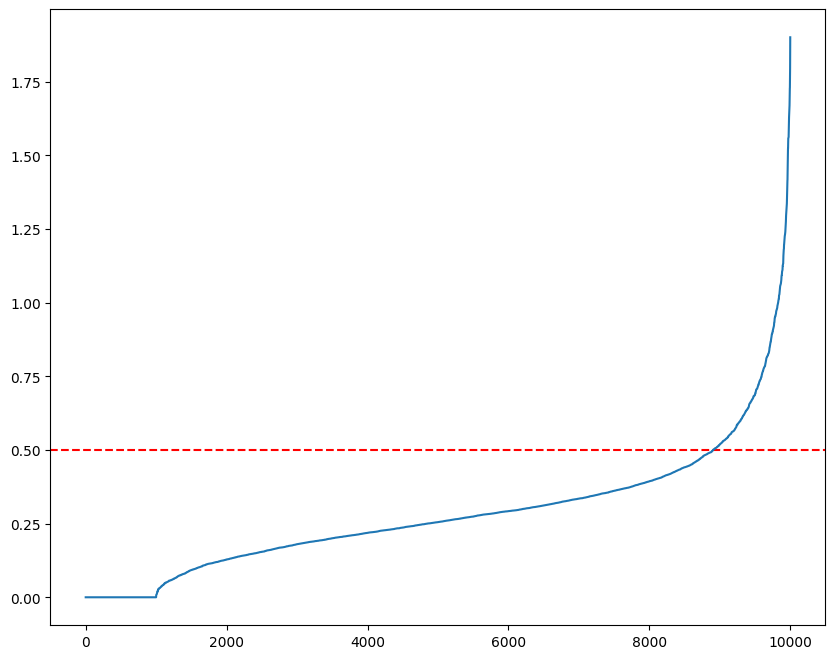

In [6]:
# Cargamos NeighborsNeighbors
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors = 10)
nbrs = neigh.fit(X)
distancias, indices = nbrs.kneighbors(X)
distancias = np.sort(distancias.flatten())
fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = 0.5, color = 'r', linestyle = '--')
plt.plot(distancias)

En la gráfica se puede ver que la parte exponencial de la curva comienza alrededor de una distancia de 0.5. Para detectar este punto más fácilmente podemos usar la librería `kneed` que permite detectar estos puntos.

In [7]:
from kneed import KneeLocator

i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

print(distancias[knee.knee])

0.4715365000893866


Podemos ver entonces que el punto detectado es `0.47` y cómo cambian nuestros resultados si utilizamos este valor de `eps`.

Text(0.5, 1.0, 'Se encontraron 4 clusteres para epsilon 0.47')

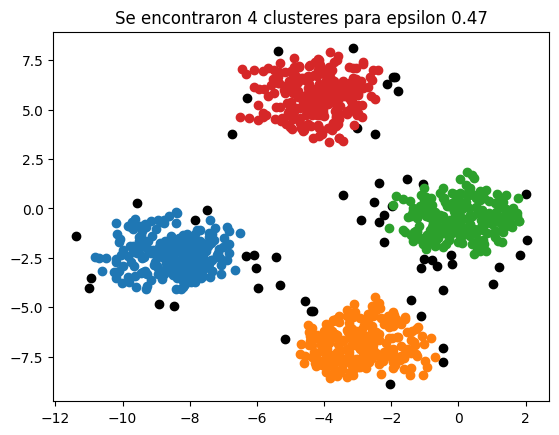

In [8]:
db = DBSCAN(eps = 0.47, min_samples = 4).fit(X)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(X).assign(Cluster = clusteres)
plt.figure()
for k in np.unique(clusteres):
    if k != -1:
        plt.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1]
            )
    else:
        plt.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            c = "black"
            )
plt.title('Se encontraron %d clusteres para epsilon %0.2f' % (n_clusteres, 0.47))

#### Elección de `min_samples`

El otro componente central para una implementación exitosa de DBSCAN es el número mínimo de puntos necesarios para justificar la pertenencia a un grupo (`min_samples`). Para elegir este parámetro sin embargo no existe un método como el anteriormente mencionado, la elección depende del conocimiento y experiencia de quien implementa el algoritmo.

Sin embargo, hay algunas consideraciones a tener en cuenta al momento de elegir este parámetro.

   - Cuanto más grande sea el número de observaciones, más grande debe ser `min_samples`. 
   - Cuanto más ruidosa es la base, más grande debe ser `min_samples`. 
   - `min_samples` debe aumentar con la dimensionalidad de los datos. Para datos con dos dimensiones, se puede utilizar el valor de `min_samples=4` sugerido por Ester et al. (1996). Si hay más de dos dimensiones, Sander et al., (1998) sugieren utilizar al menos `min_samples= 2*dim`.
     
Es importante entonces tener en cuenta que la función de este parámetro es suavizar las densidades. Veamos entonces los efectos de distintos valores de `min_samples` en nuestro ejercicio:

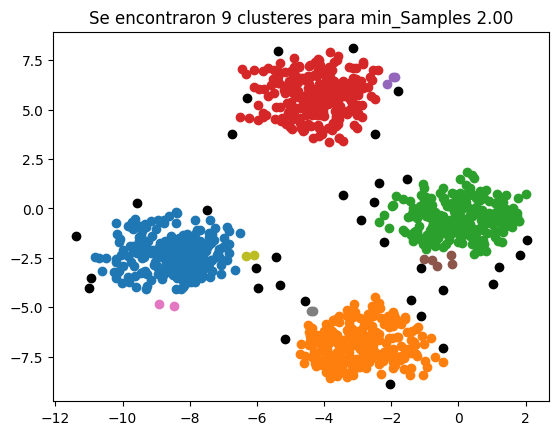

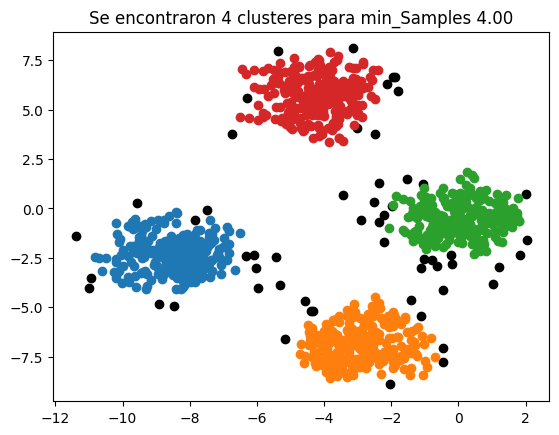

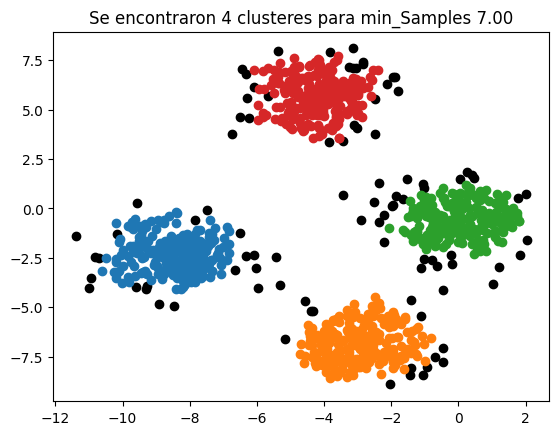

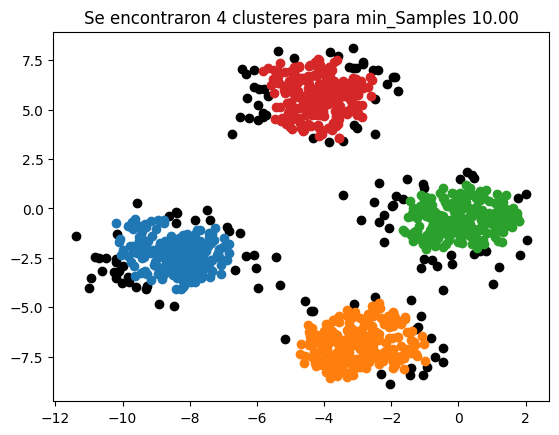

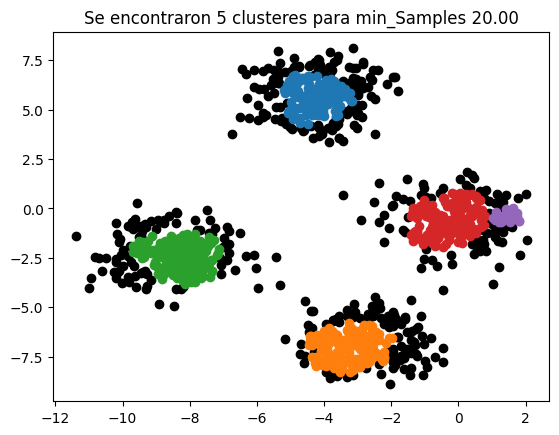

In [9]:
for minpts in [2, 4, 7, 10, 20]:
    db = DBSCAN(eps = .47, min_samples = minpts).fit(X)
    clusteres = db.labels_
    n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
    resultado = pd.DataFrame(X).assign(Cluster = clusteres)
    plt.figure()
    for k in np.unique(clusteres):
        if k != -1:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0], 
                y = resultado.loc[resultado.Cluster == k, 1]
                )
        else:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0], 
                y = resultado.loc[resultado.Cluster == k, 1],
                c = "black"
                )
    plt.title('Se encontraron %d clusteres para min_Samples %0.2f' % (n_clusteres, minpts))


Notemos entonces, que un `min_samples` bajo ayuda al algoritmo a crear más clústeres con más ruido. Un `min_samples` más alto garantizará clústeres más sólidos, pero si es demasiado grande, los clústeres más pequeños se incorporarán a clústeres más grandes. 

### Comparación entre DBSCAN, K-medias y clustering jerárquico.

Antes de finalizar este *cuaderno* comparemos el desempeño entre DBSCAN, K-medias y clustering jerárquico en dos conjuntos de datos con diferentes procesos generadores: (i) un conjunto convexo y relativamente sencillo con clara separación de clústeres, (ii) un conjunto de datos no convexos.

Crearemos entonces el primer conjunto de datos ficticios con `make_blobs`. Estos datos van a tener 3 clústeres subyacentes.

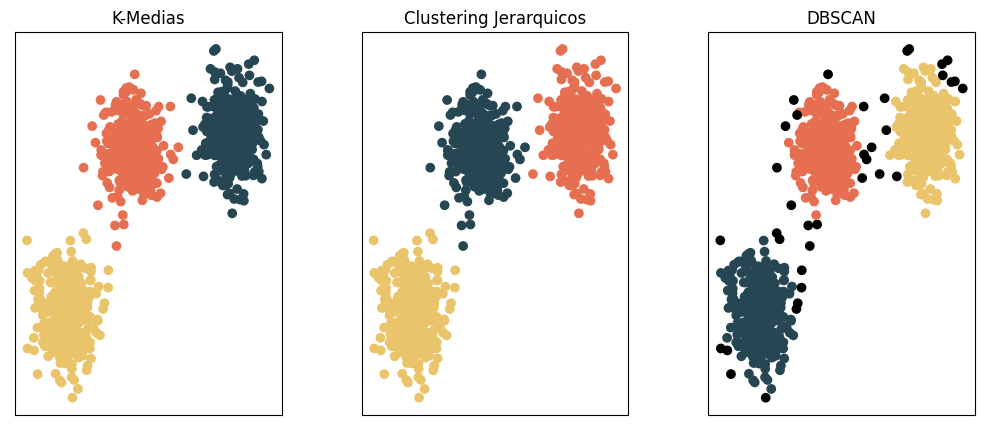

In [10]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


X, y = datasets.make_blobs(n_samples = 1000, centers = 3, random_state = 170)


# Utilizamos las funciones KMeans, AgglomerativeClustering y DBSCAN para encontrar los clústeres
kmedias = KMeans(n_clusters = 3, random_state = 123, n_init=10).fit(X)
jerarquico = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
dbscan = DBSCAN(eps = 0.5, min_samples = 4)

metodología = (
                ('K-Medias', kmedias),
                ('Clustering Jerarquicos', jerarquico),
                ('DBSCAN', dbscan)
            )

# Visualizamos los resultados
n = 0
fig, axs = plt.subplots(1, 3,figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
axs = axs.flatten()
plt.subplots_adjust(left = .02, right = .98, bottom = .001, top = .96, wspace = .3, hspace = .2)
colores = ["#264653", "#e9c46a", "#e76f51", "#2a9d8f", "#f4a261", "#d00000"]
diccionario = {-1: "black", 0: colores[0], 1: colores[1], 2: colores[2],   3: colores[3]}

for nombre, enlace in metodología:
    enlace.fit(X)
    y_pred = enlace.labels_.astype(int)
    if n in range(0, 4):
        axs[n].title.set_text(nombre)
        color = [diccionario[k] for k in y_pred]
        axs[n].scatter(X[:, 0], X[:, 1], c = color)
        axs[n].set_xticks([])
        axs[n].set_yticks([])
        n += 1
        
plt.show()

Estas figuras ilustran que con clústeres "bien formados", no existen diferencias sustanciales en la asignación a clústeres. DBSCAN, sin embargo, a diferencia de las otras metodologías designa como ruido (los puntos en negro) a aquellos puntos en los bordes y limítrofes.

Veamos ahora el desempeño con clústeres no convexos. Para ello vamos a generar datos que pertenecen a dos grupos y estos grupos tienen una forma de luna, que claramente son clústeres no convexos.

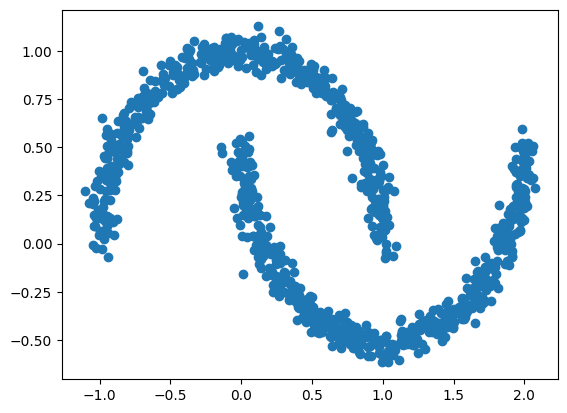

In [11]:
from sklearn import cluster, datasets

X, y  = datasets.make_moons(n_samples = 1000, noise = .05, random_state = 123)
plt.scatter(X[:,0], X[:,1])
plt.show()

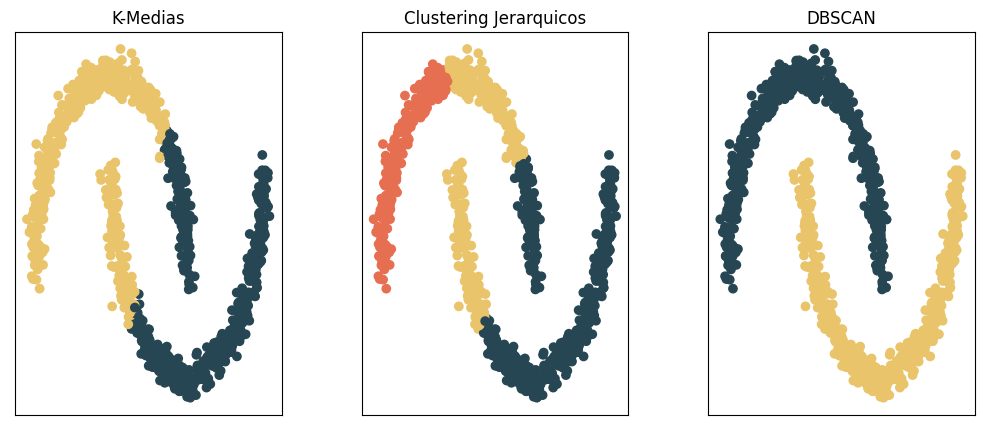

In [12]:
# Utilizamos las funciones KMeans, AgglomerativeClustering y DBSCAN para encontrar los clústeres
kmedias = KMeans(n_clusters = 2, random_state = 123, n_init=10).fit(X)
jerárquico = AgglomerativeClustering(n_clusters = 2, linkage = 'ward')
dbscan = DBSCAN(eps = 0.2, min_samples = 4)

metodologia = (
                ('K-Medias', kmedias),
                ('Clustering Jerarquicos', jerarquico),
                ('DBSCAN', dbscan)
            )

# Visualizamos los resultados
n = 0
fig, axs = plt.subplots(1, 3,figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
axs = axs.flatten()
plt.subplots_adjust(left = .02, right = .98, bottom = .001, top = .96, wspace = .3, hspace = .2)
colores = ["#264653", "#e9c46a", "#e76f51", "#2a9d8f", "#f4a261", "#d00000"]
diccionario = {-1: "black", 0: colores[0], 1: colores[1], 2: colores[2],   3: colores[3]}

for nombre, enlace in metodologia:
    enlace.fit(X)
    y_pred = enlace.labels_.astype(int)
    if n in range(0, 4):
        axs[n].title.set_text(nombre)
        color = [diccionario[k] for k in y_pred]
        axs[n].scatter(X[:, 0], X[:, 1], c = color)
        axs[n].set_xticks([])
        axs[n].set_yticks([])
        n += 1
        
plt.show()

Notemos que en este caso, aún conociendo que el proceso generador de datos contiene 2 clústeres, el único método que realiza un trabajo razonable es DBSCAN dada la forma compleja de los datos.

Para continuar explorando cómo cambian los resultados dependiendo de los enlaces, los invito a explorar qué sucede cuando tenemos datos que siguen los siguientes cuatro procesos generadores de datos:

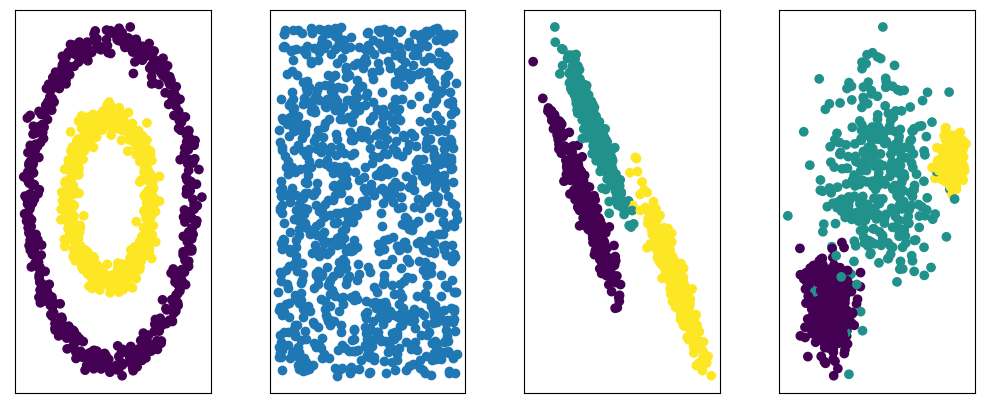

In [13]:
n_observaciones = 1000
# Creamos 4 bases de datos con mecanismos generadores de datos diferentes.
circulos = datasets.make_circles(n_samples = n_observaciones, factor = .5, noise = .05, random_state = 666)
aleatorio = np.random.rand(n_observaciones, 2), None
nubes = datasets.make_blobs(n_samples = n_observaciones, centers = 3, random_state = 170)
transformacion = [[0.6, -0.6], [-0.4, 0.8]]
X_nubes2 = np.dot(nubes[0], transformacion)
nubes2 = (X_nubes2, nubes[1])

nubes3 = datasets.make_blobs(n_samples = n_observaciones, centers = 3, cluster_std = [1.0, 2.5, 0.5], random_state = 170)

datos = [
    (circulos, {'n_clusteres': 2}),
    (aleatorio, {'n_clusteres': 3}), 
    (nubes2, {'n_clusteres': 3}), 
    (nubes3, {'n_clusteres': 3})
    ]


fig, axs = plt.subplots(1, 4,figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplots_adjust(left = .02, right = .98, bottom = .001, top = .96, wspace = .3, hspace = .2)
 
axs = axs.ravel()
n = 0
for df in datos:
    df = df[0]
    axs[n].scatter(x = df[0][:,0], y = df[0][:,1], c = df[1])
    axs[n].set_xticks([])
    axs[n].set_yticks([])
    n += 1

## Consideraciones Finales 


Antes de finalizar es importante recalcar que DBSCAN al igual que clustering jerárquico tiene la ventaja, a diferencia de los métodos basados en centroides como K-medias o K-medoides,que no es necesario elegir a priori el número de clústeres. Sin embargo, es necesario especificar `eps`, pero que tenemos una aproximación de cómo encontrarlo. 

Por otro lado, DBSCAN a diferencia de  K-medias o K-medoides como el clustering jerárquico no asigna forzosamente a todas las observaciones a un cluster. Esto es particularmente útil en la presencia de valores atípicos o ruido en la muestra. Asimismo DBSCAN, como vimos en el inciso anterior, es robusto a la forma de los clústeres, lo cuál es una ventaja en el caso de clústeres no convexos.

Un punto que no tocamos en este *cuaderno* pero que los invito a explorar es la cuestión de que si los resultados son robustos a que los datos estén escalados o no. Puesto que el cálculo de la distancia es un paso intermedio, la varianza de los datos va a jugar un rol importante repercute en los resultados, pero esta decisión como las anteriores dependerán del problema bajo estudio.

Finalmente, DBSCAN puede presentar ciertas ventajas. En primer lugar, es un método determinístico sólo cuando el orden de los datos sea el mismo. Esto implica que los resultados van a cambiar si se permuta el orden de procesamiento de los datos. Esto hace que en si mismo sea un método no robusto. Al mismo tiempo, si la densidad de los clústeres es distinta, será difícil encontrar parámetros  `eps` y `min_samples` globales que permitan una agrupación adecuada.


# Referencias

- Ester, M., H. P. Kriegel, J. Sander, and X. Xu. (1996). A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise. In Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226–231. 

- Jones, Aaron; Kruger, Christopher; Johnston, Benjamin. The Unsupervised Learning Workshop: Get started with unsupervised learning algorithms and simplify your unorganized data to help make future predictions. Packt Publishing. Kindle Edition. 

- Sander, J., Ester, M., Kriegel, HP. et al. Density-Based Clustering in Spatial Databases: The Algorithm GDBSCAN and Its Applications. Data Mining and Knowledge Discovery 2, 169–194 (1998). https://doi.org/10.1023/A:1009745219419

- Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). DBSCAN revisited, revisited: why and how you should (still) use DBSCAN. In ACM Transactions on Database Systems (TODS), 42(3), 19.

- Rahmah, N., & Sitanggang, I. S. (2016). Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to Clustering Data on Peatland Hotspots in Sumatra. In IOP Conference Series: Earth and Environmental Science (Vol. 31, p. 012012). IOP Publishing. https://doi.org/10.1088/1755-1315/31/1/012012

# Información de Sesión

In [14]:
import session_info

session_info.show(html=False)

-----
kneed               0.8.5
matplotlib          3.5.3
numpy               1.21.6
pandas              1.3.5
scipy               1.7.3
session_info        1.0.0
sklearn             1.0.2
-----
IPython             7.34.0
jupyter_client      7.4.9
jupyter_core        4.12.0
jupyterlab          2.1.1
notebook            6.0.3
-----
Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) [GCC 7.3.0]
Linux-6.5.0-1020-aws-x86_64-with-debian-buster-sid
-----
Session information updated at 2024-08-25 00:29
